In [1]:
import simulate
import withdrawal
import market
import harvesting
import metrics
import lens

from decimal import Decimal as D
import decimal
import itertools
import pandas
import numpy
import math
#import ipysheet

In [2]:
%matplotlib inline
import seaborn
from matplotlib import pyplot as plt
import matplotlib
seaborn.set(style="whitegrid")
seaborn.set_context('poster')

/Users/justus/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
Omegas = [harvesting.make_omeganot(D(n)/100) for n in range(70,140, 10)]
Rebalances = [harvesting.make_rebalancer(D(n)/100) for n in range(20, 110, 10)]
Glidepaths = [harvesting.Glidepath, harvesting.InverseGlidepath, harvesting.AgeBased_100]

Omega100 = harvesting.make_omeganot(D(1))
Rebalance75 = harvesting.make_rebalancer(D(75)/100)

Constant_04 = withdrawal.make_constantdollar(D('.04'))
Constant_05 = withdrawal.make_constantdollar(D('.05'))

In [4]:
def run2(a_lens, harvest1, harvest2, withdraw=Constant_05, length=40):
    s1 = simulate.calc_lens(harvest1, withdraw, length, a_lens)
    s2 = simulate.calc_lens(harvest2, withdraw, length, a_lens)
    df = pandas.DataFrame({harvest1.__name__: s1, harvest2.__name__: s2})
        
    g = seaborn.relplot(
        data=df.loc[1965:1975],
#        aspect=4,
    )
    g.fig.autofmt_xdate()
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle('Individual year comparisons: 1965 - 1975')
    return (g, df)

def run_deciles(a_lens, harvest1, harvest2, withdraw=Constant_05, length=40):
    s1 = simulate.calc_lens(harvest1, withdraw, length, a_lens).astype(float)
    s2 = simulate.calc_lens(harvest2, withdraw, length, a_lens).astype(float)
    
    bins = 5

    df = pandas.DataFrame(index=numpy.arange(0, 100, bins), columns=[harvest1.__name__, harvest2.__name__])
    for i in range(0, 100, bins):
        df.loc[i] = (s1.quantile(i/100), s2.quantile(i/100))
    
    g = seaborn.relplot(
        data=df,
        aspect=2,
    )
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle('Grouped by quantiles (5%, 10%, 15%, etc.)')    
    return (g, df)

def by_year(year, lens, harvest1, harvest2, years=40):
    MARKET = market.Returns_US_1871()
    s1 = simulate.withdrawals(MARKET.iter_from(year), harvesting=harvest1, withdraw=withdrawal.make_vpw(years+5), years=years)
    s2 = simulate.withdrawals(MARKET.iter_from(year), harvesting=harvest2, withdraw=withdrawal.make_vpw(years+5), years=years)

    df = pandas.DataFrame({harvest1.__name__: [lens(x) for x in s1], harvest2.__name__: [lens(x) for x in s2]})
    g = seaborn.relplot(
        data=df[df[harvest1.__name__] < 40000],
        aspect=4,
    )
    g.despine(left=True, bottom=True, offset=20)
    g.fig.suptitle(year)
    return (g, df)

def ulcer_floor(series, floor=40000):
    sumsq = 0
    for value in [float(n) for n in series]:
        if value < floor:
            drawdown = (100 * ((value / floor) - 1))
            sq = drawdown ** 2
            sumsq += sq
    return math.sqrt(sumsq / len(series)) / 100

def wd_r(x):
    return x.withdraw_r
def port_r(x):
    return x.portfolio_pre.value_r

In [5]:
L = 40

# Shortfall Years

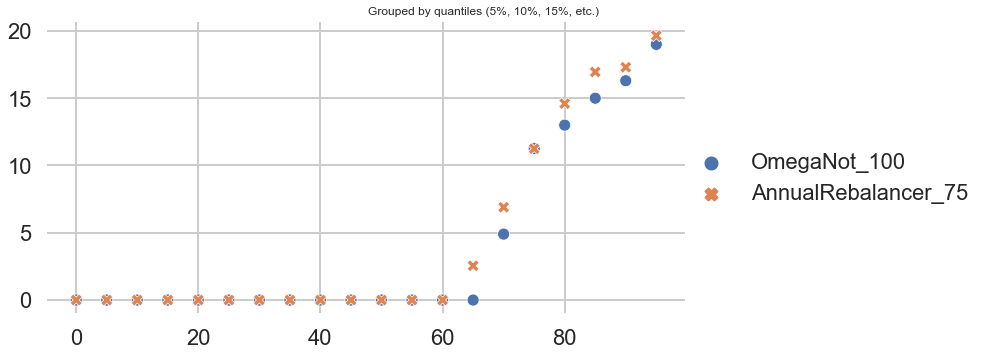

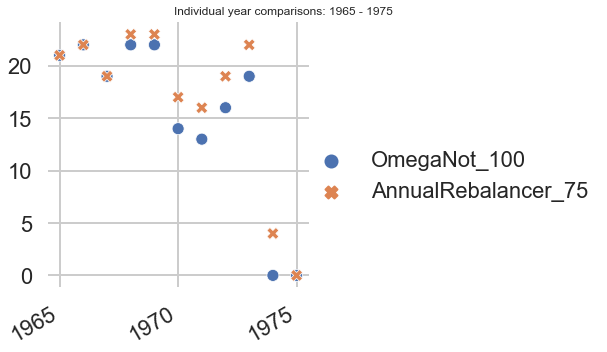

In [6]:
run_deciles(lens.calc_shortfall_years, Omega100, Rebalance75)[0]
run2(lens.calc_shortfall_years, Omega100, Rebalance75)[0]

# PWA0

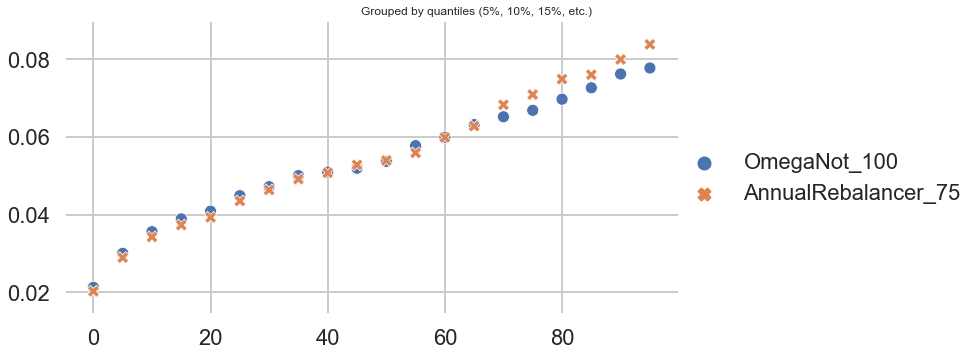

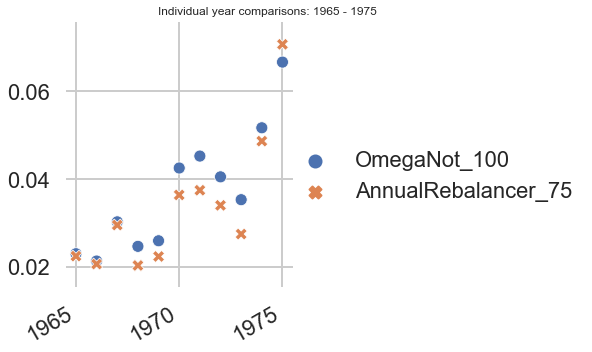

In [7]:
run_deciles(lens.calc_pwa0, Omega100, Rebalance75)[0]
run2(lens.calc_pwa0, Omega100, Rebalance75)[0]

# Coverage Ratio

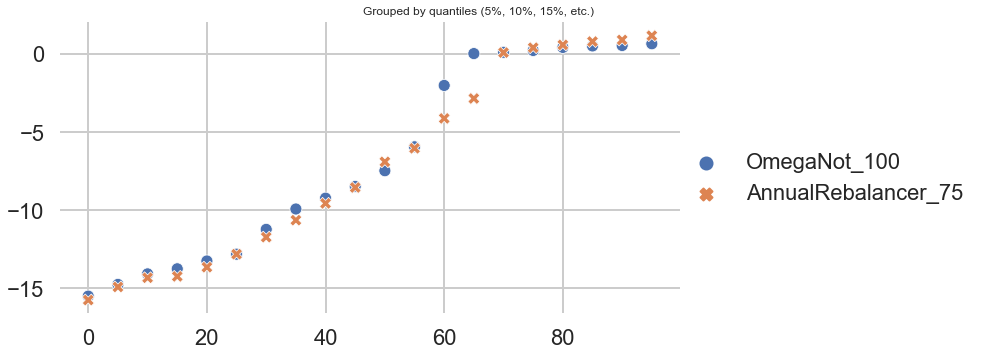

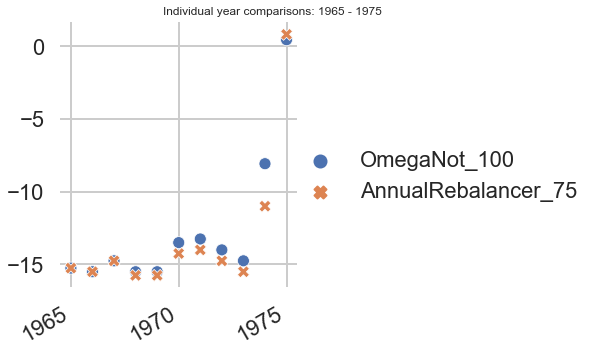

In [8]:
run_deciles(lambda a: lens.calc_coverage_ratio(a, L), Omega100, Rebalance75, length=L)[0]
run2(lambda a: lens.calc_coverage_ratio(a, L), Omega100, Rebalance75, length=L)[0]

# Ulcer Index (Portfolio)

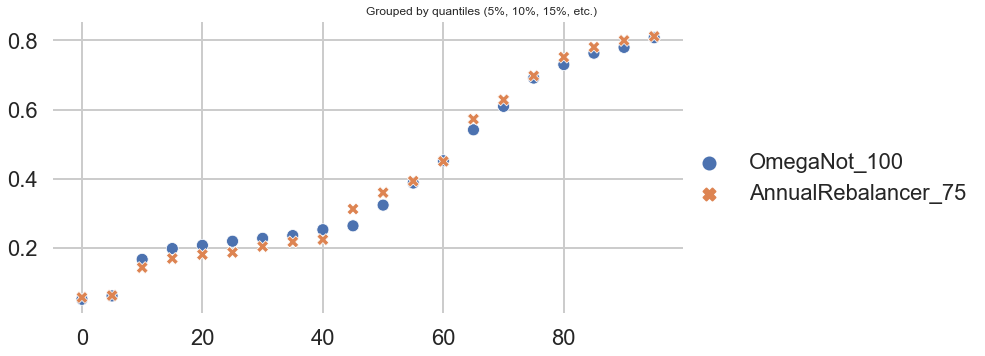

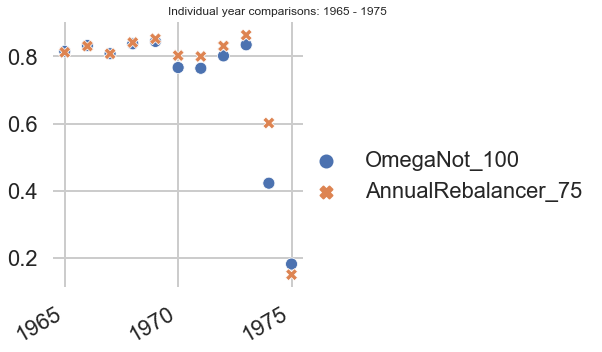

In [9]:
run_deciles(lens.calc_ulcer, Omega100, Rebalance75)[0]
run2(lens.calc_ulcer, Omega100, Rebalance75)[0]

# Ulcer Index (Withdrawals)

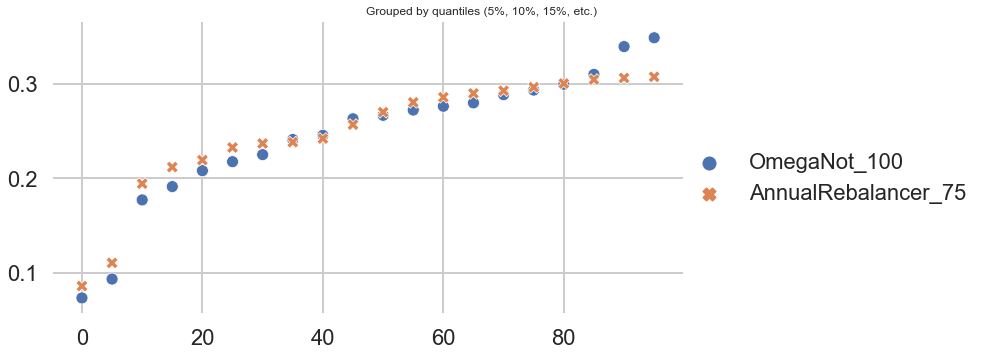

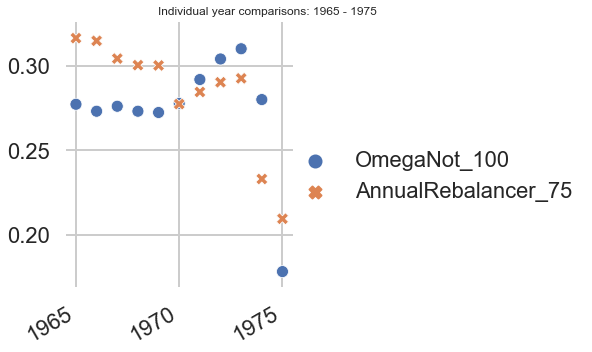

In [10]:
run_deciles(lambda a: metrics.ulcer([n.withdraw_r for n in a]), Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))[0]
run2(lambda a: metrics.ulcer([n.withdraw_r for n in a]), Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))[0]

# CEW

OmegaNot_100           34934.69436577770387344454577
AnnualRebalancer_75    32192.98089468916246986413176
Name: 1969, dtype: object

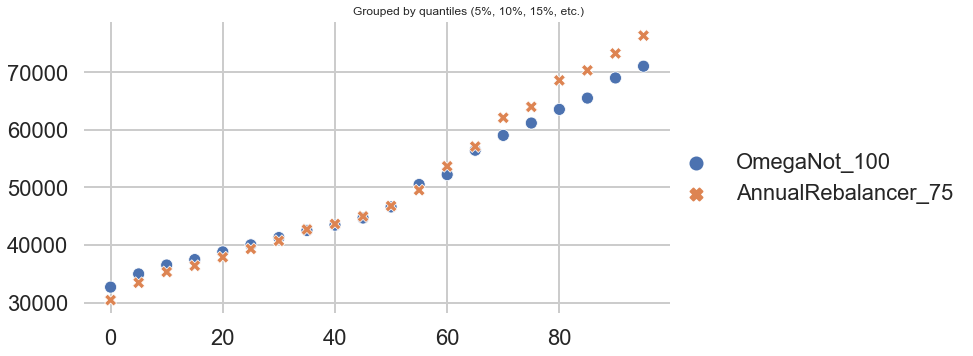

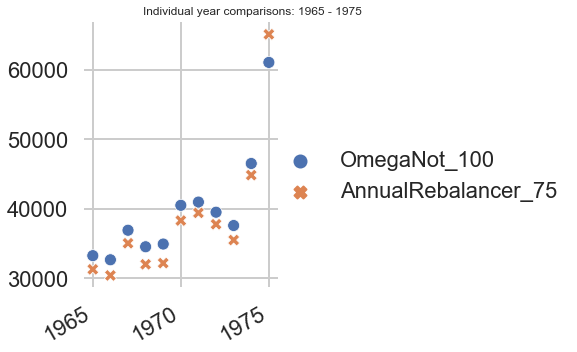

In [11]:
run_deciles(lens.calc_cew, Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))[0]
g, df = run2(lens.calc_cew, Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))
g
df.loc[1969]

# HREFF-4

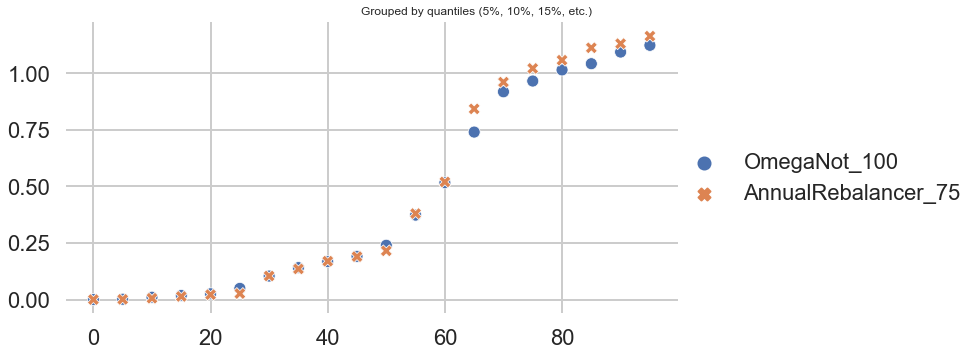

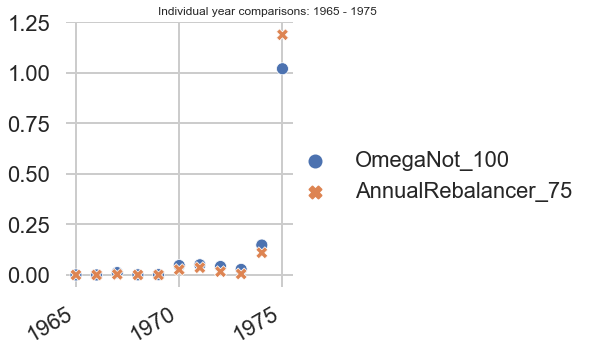

In [12]:
run_deciles(lens.calc_hreff, Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))[0]
g, df = run2(lens.calc_hreff, Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))
g

In [13]:
df.loc[1969]

OmegaNot_100            0.001356823152058444492614093803
AnnualRebalancer_75    0.0002111056724444280037617052103
Name: 1969, dtype: object

# HREFF-3

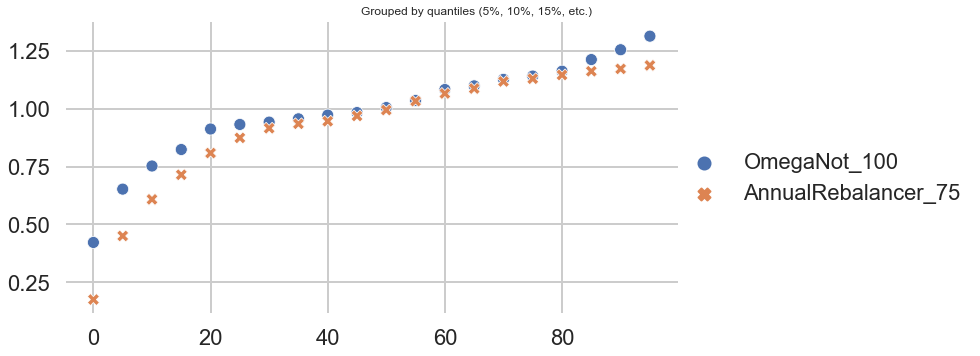

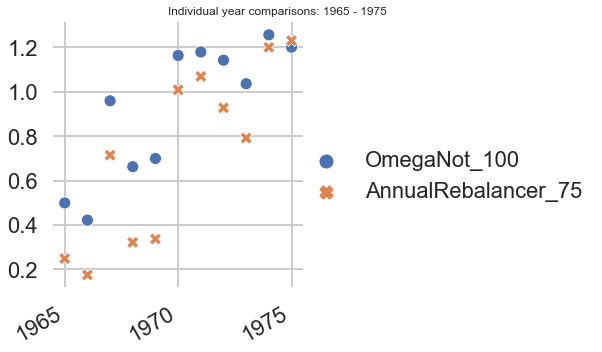

In [14]:
run_deciles(lambda a: lens.calc_hreff(a, floor=D('.025')), Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))[0]
g, df = run2(lambda a: lens.calc_hreff(a, floor=D('.025')), Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))
g

In [15]:
df.loc[1969]

OmegaNot_100           0.6992140731225387622638126243
AnnualRebalancer_75    0.3364706422427970510582359736
Name: 1969, dtype: object

# Ulcer Floor (Withdrawals)

OmegaNot_100           0.169616
AnnualRebalancer_75    0.201883
Name: 1969, dtype: float64

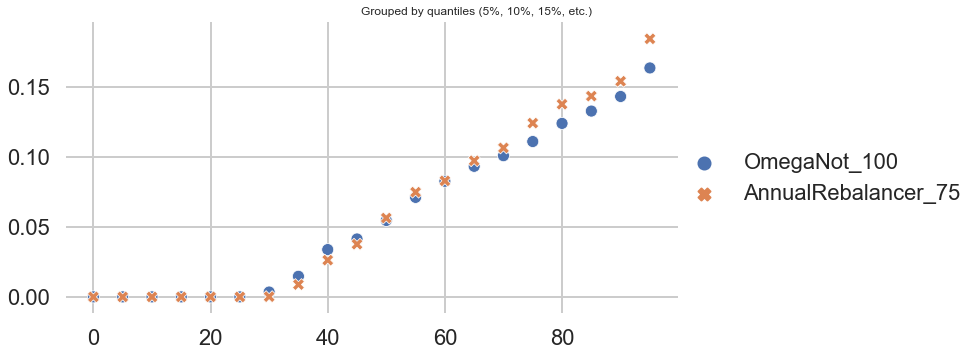

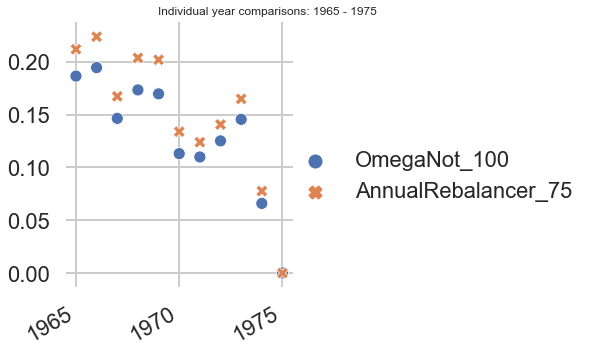

In [16]:
run_deciles(lambda a: ulcer_floor([n.withdraw_r for n in a]), Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))[0]
g, df = run2(lambda a: ulcer_floor([n.withdraw_r for n in a]), Omega100, Rebalance75, withdraw=withdrawal.make_vpw(L+5))
g
df.loc[1969]

# Compare Yearly Withdrawals

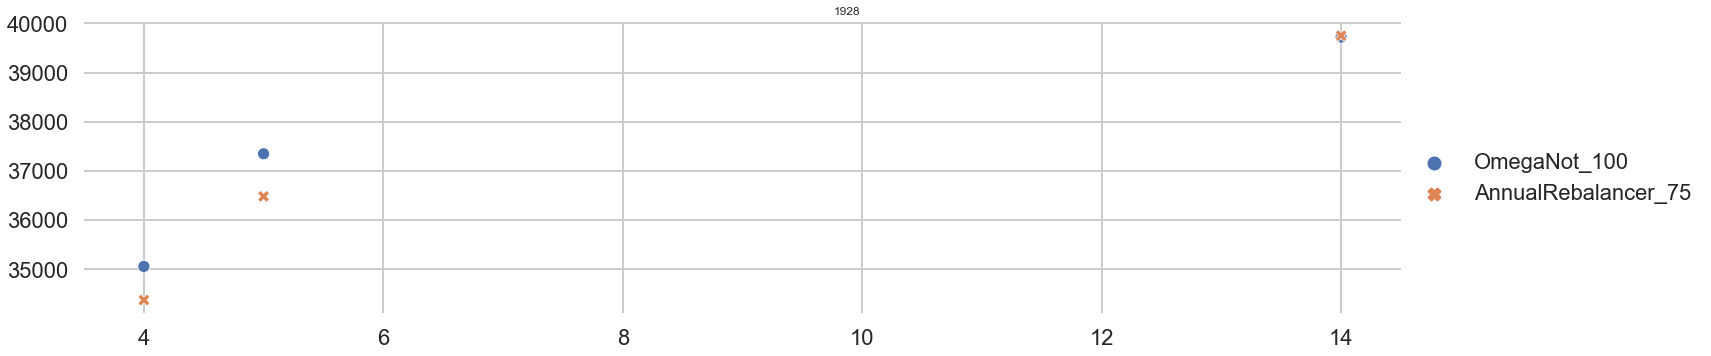

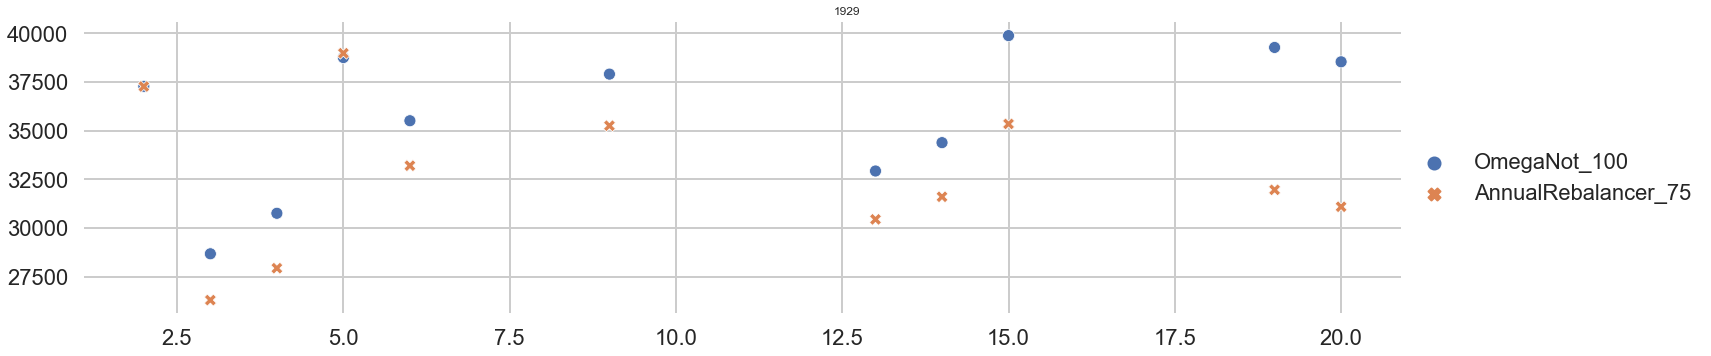

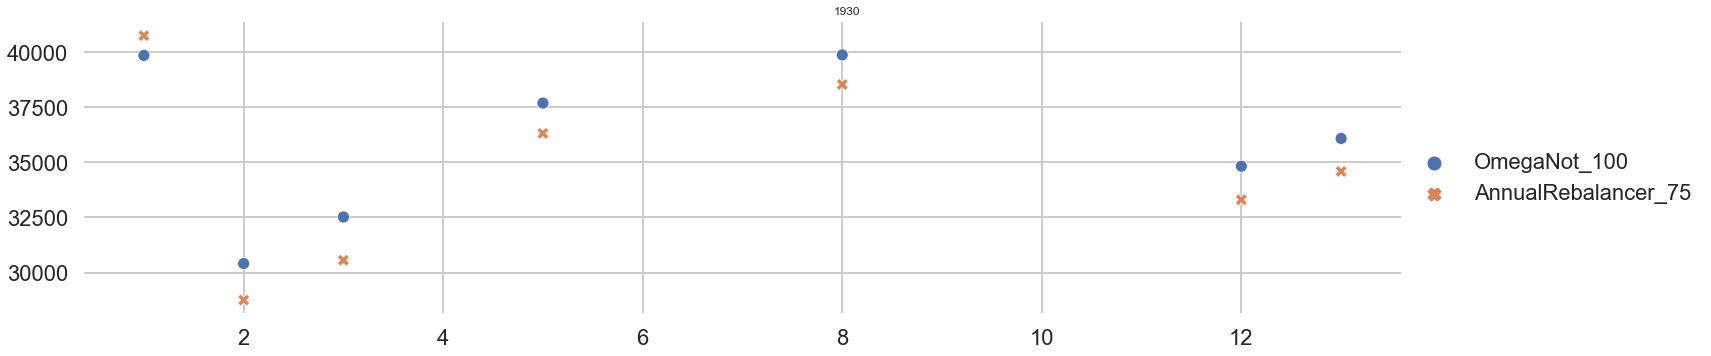

In [17]:
for i in range(1928, 1931):
    by_year(i, wd_r, Omega100, Rebalance75)[0]

# Build difference of all withdrawals for all years

We only care about years where the Rebalance strategy fell below our floor of $40,000

In [18]:
def build_ulcer_diffs(harvest1, harvest2, floor=40000):
    L = 40
    MARKET = market.Returns_US_1871()
    end_year = 2018 - L + 1
    
    ulcers = pandas.Series(index=numpy.arange(MARKET.start_year, end_year))
    
    for start in range(MARKET.start_year, end_year):
        sim1 = simulate.withdrawals(MARKET.iter_from(start), harvesting=harvest1, withdraw=withdrawal.make_vpw(L+5), years=L)
        sim2 = simulate.withdrawals(MARKET.iter_from(start), harvesting=harvest2, withdraw=withdrawal.make_vpw(L+5), years=L)

        s1 = pandas.Series([wd_r(x) for x in sim1]).clip(upper=floor)
        s2 = pandas.Series([wd_r(x) for x in sim2]).clip(upper=floor)
        ulcers.loc[start] = metrics.ulcer(s2) - metrics.ulcer(s1)

    return ulcers

# Build Ulcer Diff for all years

A higher number means Rebalance was *worse*

In [19]:
ulcer_diffs = build_ulcer_diffs(Omega100, Rebalance75)
ulcer_diffs.sort_values(ascending=False).head()

1929    0.039853
1969    0.032268
1968    0.030306
1966    0.029257
1965    0.025354
dtype: float64

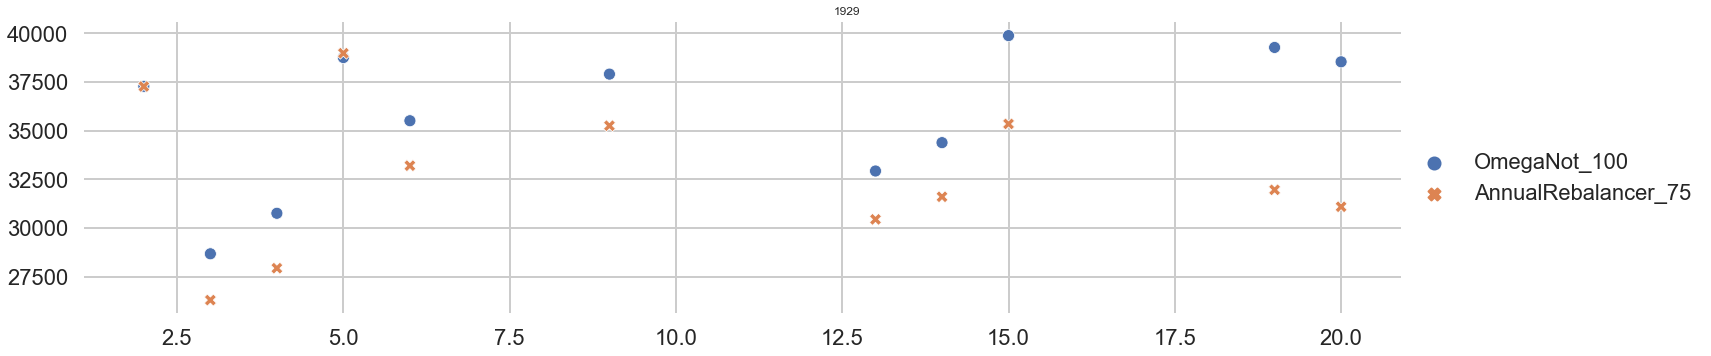

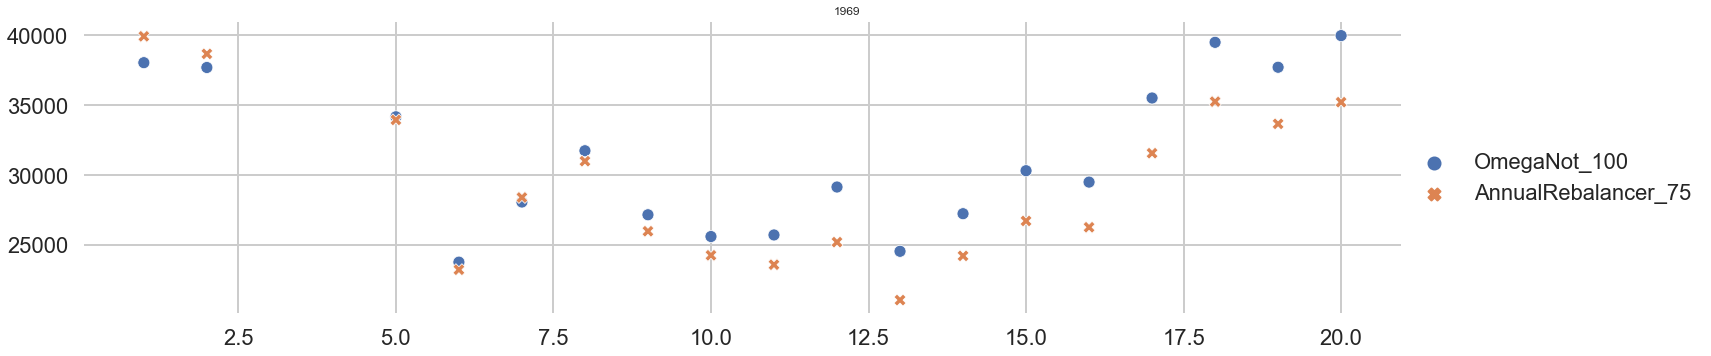

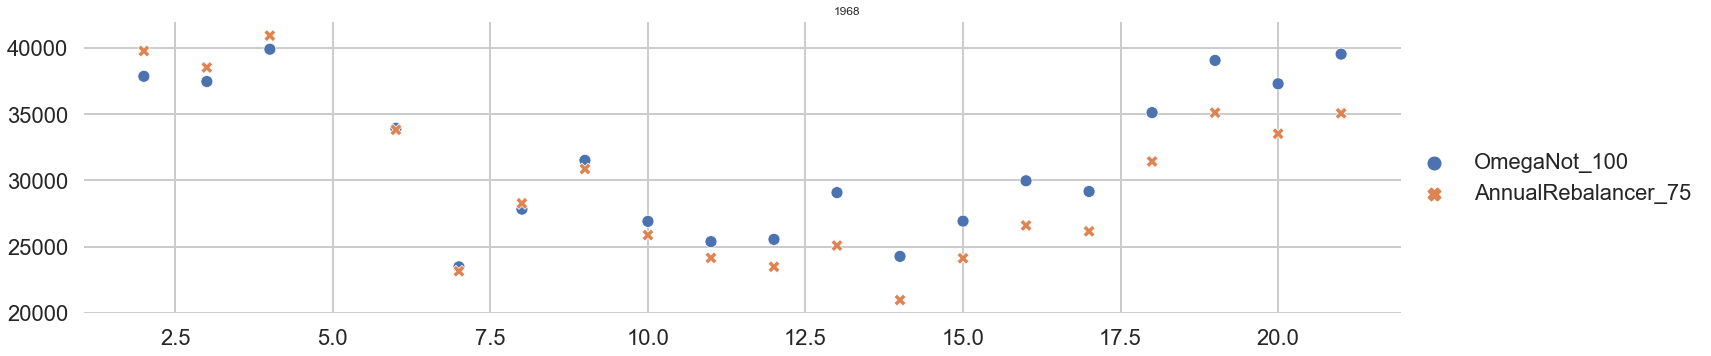

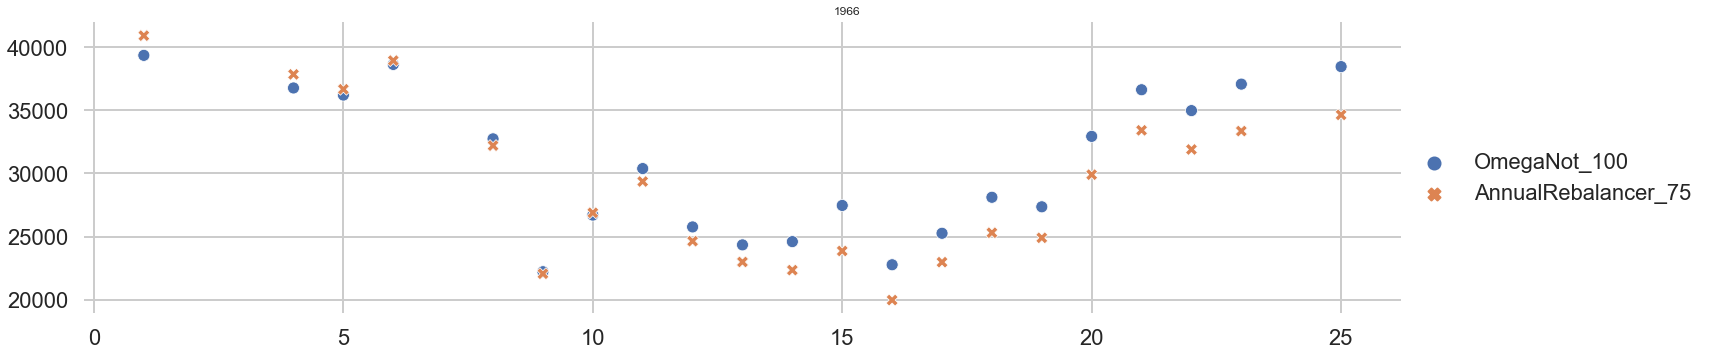

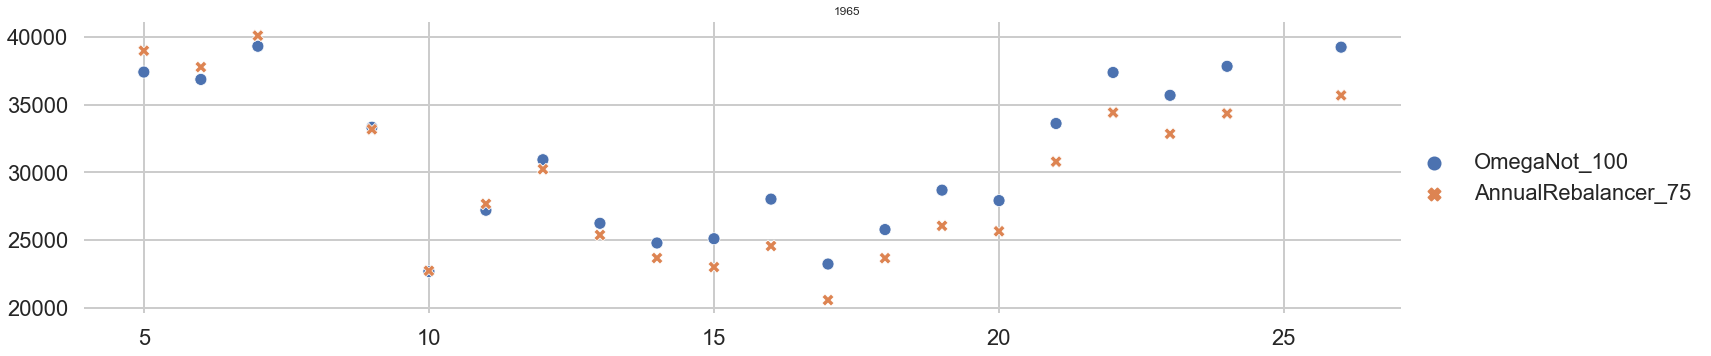

In [20]:
for x in ulcer_diffs.sort_values(ascending=False).index[0:5]:
    by_year(x, wd_r, Omega100, Rebalance75)[0]

# The opposite

But we also want to check the opposite...cases where OmegaNot100 does *worse*

In [21]:
ulcer_diffs.sort_values(ascending=True).head()

1885   -0.017033
1884   -0.011679
1883   -0.010288
1882   -0.009497
1934   -0.008401
dtype: float64

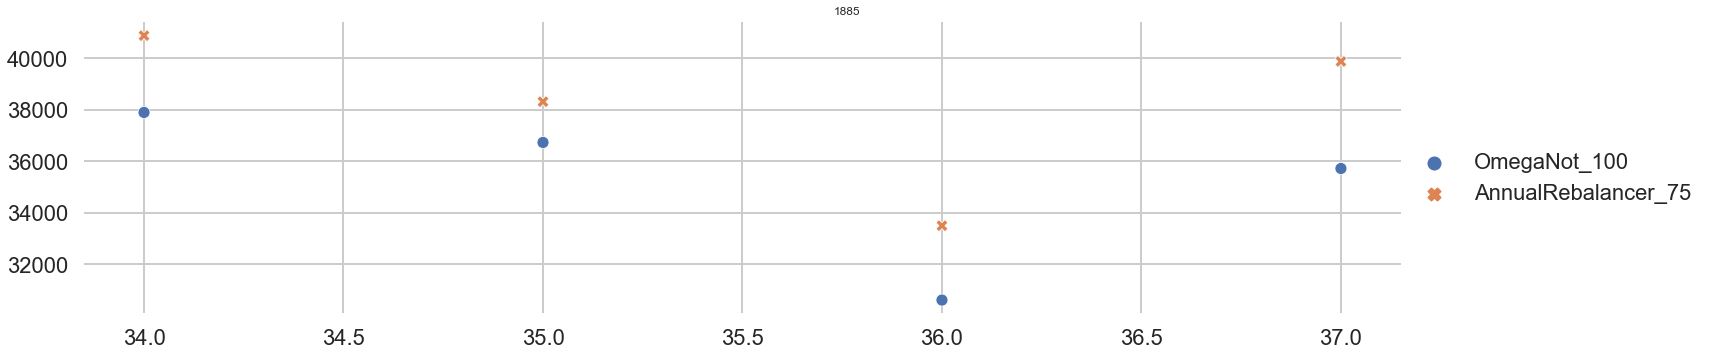

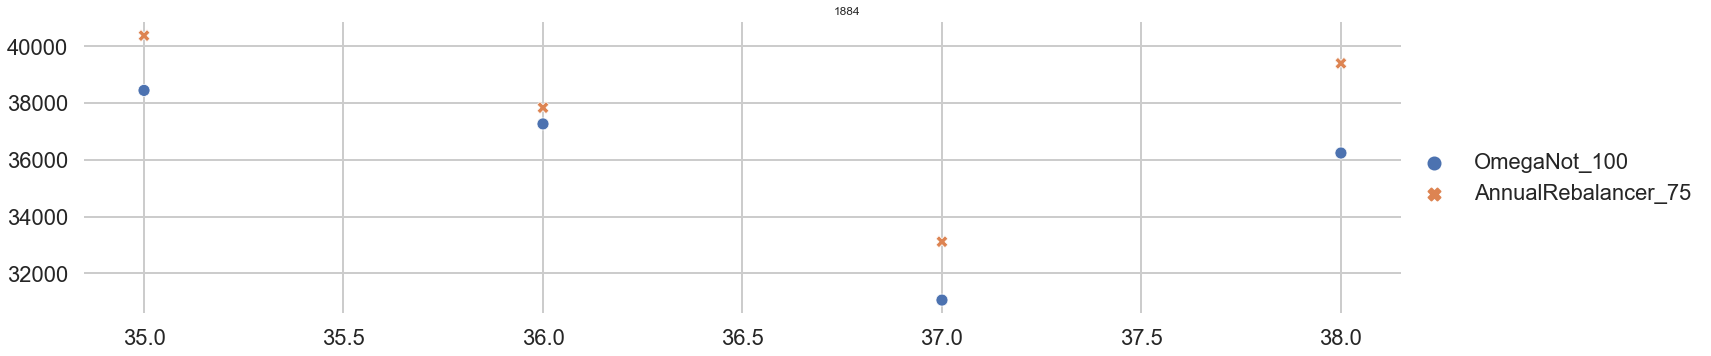

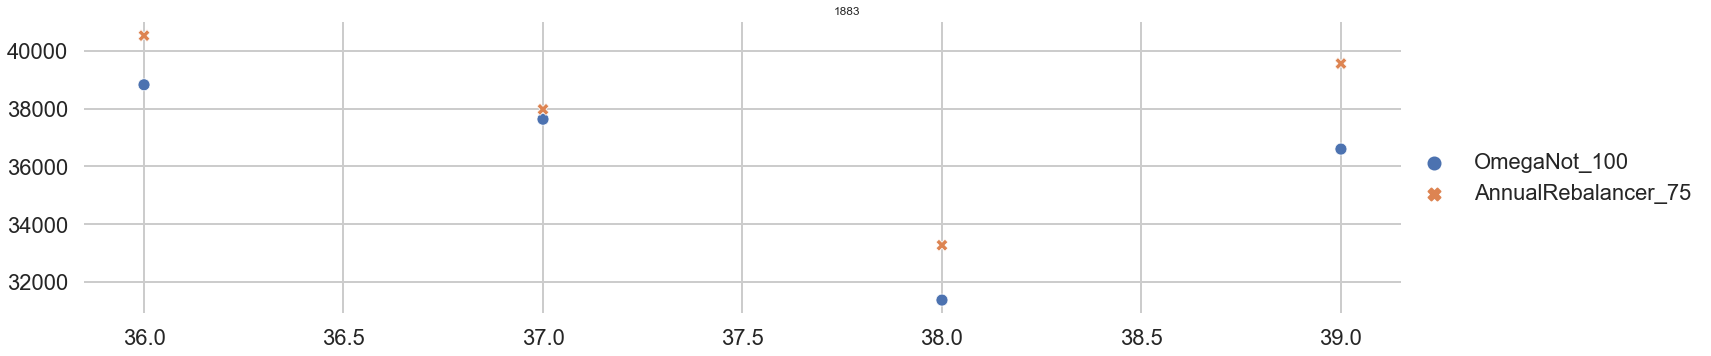

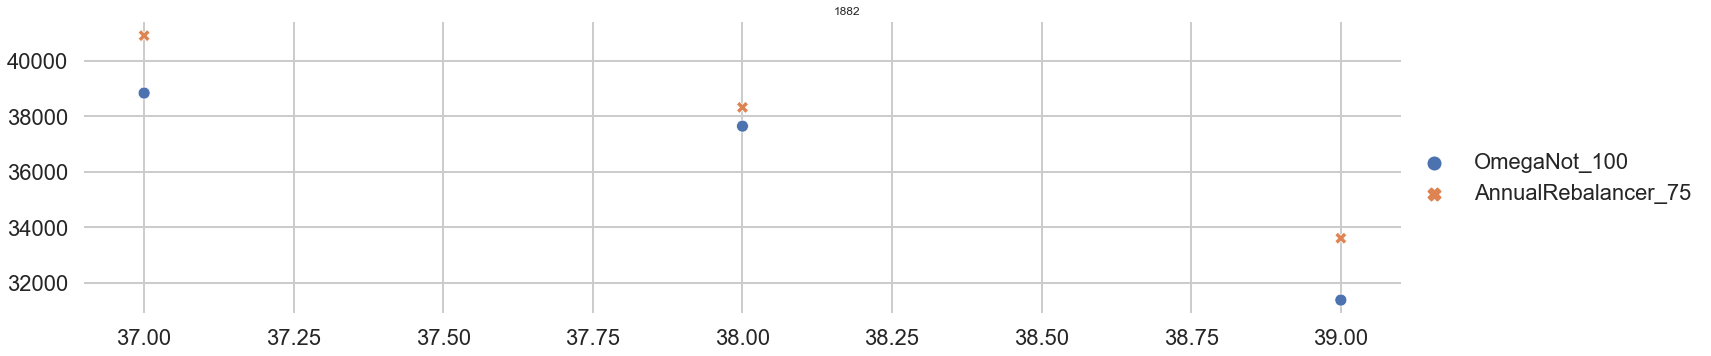

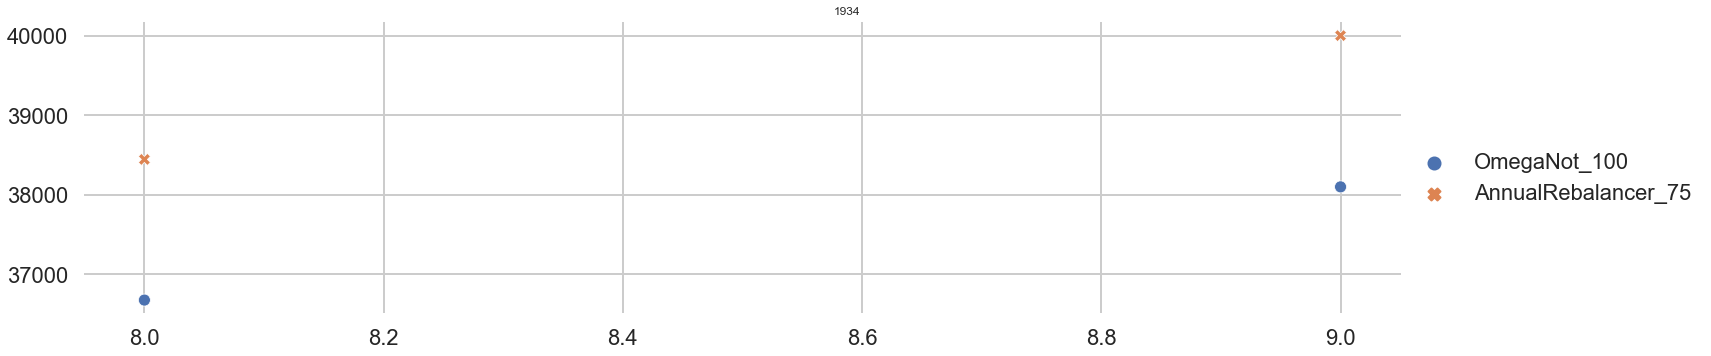

In [22]:
for x in ulcer_diffs.sort_values(ascending=True).index[0:5]:
    by_year(x, wd_r, Omega100, Rebalance75)[0]